# Reflection Loop

A **reflection loop** is an agent pattern that allows iterative improvement of the quality of responses generated by an LLM.

## Characteristics of this implementation:

1. **Iterative cycle**: The agent goes through several steps before producing a final response
   - 🧠 **THINK**: Initial preparation and reflection
   - ✍️ **ANSWER**: Response generation
   - ✅ **CHECK**: Critical evaluation of the response

2. **Self-evaluation**: A separate LLM evaluates the quality of the generated response and identifies gaps

3. **Continuous improvement**: If the response is not satisfactory, the agent restarts the cycle with the critiques as additional context

4. **Retry limit**: A counter (`retries >= 2`) prevents infinite loops

5. **Shared state**: All steps share the same state (`AgentState`) containing the message history and number of attempts

This pattern significantly improves response quality by allowing the agent to self-correct.

## When to use a reflection loop?

✅ **Use when:**
- Response **quality** is critical (technical documentation, complex analyses)
- Responses must be **complete and accurate** (no missing information)
- The domain requires **rigorous validation** (architecture, code review, engineering solutions)
- You need **structured responses** with multiple criteria to meet
- Response time is **not the absolute priority**

❌ **Avoid when:**
- You need **fast responses** (real-time chatbot)
- Questions are **simple and factual** ("What is the capital of France?")
- API cost is a **major constraint** (each iteration = additional LLM calls)
- **Approximate responses are sufficient** (suggestions, brainstorming)
- You're working with **strict latency constraints**

In [1]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.7)

In [3]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    retries: int



In [4]:
SYSTEM_MESSAGE = (
    "You are a senior software engineer. \n"
    "Always think step by step. \n"
    "If the answer is incorrect or incomplete, you must improve it. \n"
    "Be concise and technical."
)

## Node 1 — THINK 🧠

In [5]:
def think_node(state: AgentState) -> AgentState:
    messages = state["messages"]

    if not any(m.type == "system" for m in messages):
        messages = [SystemMessage(content=SYSTEM_MESSAGE)] + messages
    
    messages.append(AIMessage(content="Let me thinkg carrefully before answering."))

    return {
        "messages": messages,
        "retries": state["retries"] + 1 
    }

## Node 2 — ANSWER ✍️

In [6]:
def answer_node(state: AgentState) -> AgentState:
    messages = state["messages"]
    response = llm.invoke(messages)
    return {
        "messages": messages + [response],
        "retries": state["retries"]
    }

## Node 3 — CHECK ✅

In [7]:
def check_node(state: AgentState) -> bool:
    last_message = state["messages"][-1]
    content = last_message.content
    
    human_message = HumanMessage(
        content=(
        "review the following anwser. \n"
        f"\n\nAnswer to review:\n{content}"
        "If the answer is correct and complete, reply ONLY with: OK\n"
        "Otherwise, explain briefly what is missing or incorrect.\n"
    )
    )

    system_message = SystemMessage(
        content="You are a strict reviewer. "
    )
    critique_llm = ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0
    )

    critique = critique_llm.invoke([human_message, system_message])


    return {
        "messages": state["messages"] + [critique],
        "retries": state["retries"] + (0 if critique.content.strip() == "OK" else 1)
    }

## Decision: continue or stop?

In [8]:
def should_retry(state: AgentState) -> str:
    if state["retries"] >= 2:
        return "end"

    last = state["messages"][-1].content.strip()
    return "retry" if last != "OK" else "end"


In [9]:
graph = StateGraph(AgentState)

graph.add_node("think", think_node)
graph.add_node("answer", answer_node)
graph.add_node("check", check_node)

graph.set_entry_point("think")

graph.add_edge("think", "answer")
graph.add_edge("answer", "check")

graph.add_conditional_edges(
    "check",
    should_retry,
    {
        "retry": "think",
        "end": END
    }
)

app = graph.compile()


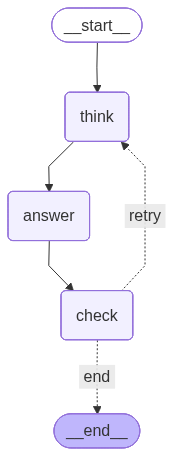

In [10]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
result = app.invoke({
    "messages": [
        HumanMessage(content="What makes software architecture good?")
    ],
    "retries": 2
})

# Get the actual answer (second to last AI message, skipping system and critique)
ai_messages = [msg for msg in result["messages"] if msg.type == "ai"]
# The pattern is: thinking message, actual answer, critique
# So we want the second to last AI message (the answer before the critique)
if len(ai_messages) >= 2:
    print(ai_messages[-2].content)
else:
    print(ai_messages[-1].content)

 

Good software architecture is the backbone of a software system, and it's essential to achieve a maintainable, scalable, and efficient system. Here are some key factors that make software architecture good:

1. **Separation of Concerns (SoC)**: The architecture should separate the system into distinct components, each responsible for a specific concern, such as business logic, data storage, and user interface.
2. **Loose Coupling**: The components should be loosely coupled, meaning they should interact with each other through well-defined interfaces, minimizing dependencies and making it easier to change or replace individual components.
3. **Single Responsibility Principle (SRP)**: Each component should have a single responsibility, making it easier to understand, maintain, and test.
4. **Modularity**: The architecture should be composed of modular components, each with its own set of dependencies and responsibilities, making it easier to manage and scale.
5. **Flexibility and Exte